# Homework 4, Question 2: Inversion

In [2]:
from __future__ import print_function, division, absolute_import

import matplotlib.pyplot as plt
import numpy as np
import dolfin as dl

plt.rcParams.update({'font.family': "Serif"})
plt.rcParams.update({'font.size': 22})

import logging
logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

TINY_SIZE = 10
SMALL_SIZE = 20
MEDIUM_SIZE = 30
BIGGER_SIZE = 40
plt.rc('font', size=SMALL_SIZE)          
plt.rc('axes', titlesize=SMALL_SIZE)     
plt.rc('axes', labelsize=SMALL_SIZE)    
plt.rc('xtick', labelsize=TINY_SIZE)    
plt.rc('ytick', labelsize=TINY_SIZE)    
plt.rc('legend', fontsize=SMALL_SIZE)    
plt.rc('figure', titlesize=MEDIUM_SIZE)

np.random.seed(seed=1)

In [3]:
def AdrInverseProblem(nx, ny, gamma, noise_level, regularization = 'h1', plotting=False, starting_location='low', run_name = "test"):
    np.random.seed(seed=1)
    mesh = dl.UnitSquareMesh(nx, ny)
    Vm = dl.FunctionSpace(mesh, 'Lagrange', 1)
    Vu = dl.FunctionSpace(mesh, 'Lagrange', 2)

    # The true and initial guess for inverted parameter
    mtrue = dl.interpolate(dl.Expression('8. - 4.*(pow(x[0] - 0.5,2) + pow(x[1] - 0.5,2) < pow(0.2,2) )', degree=5), Vm)

    # define function for state and adjoint
    u = dl.Function(Vu)
    m = dl.Function(Vm)
    p = dl.Function(Vu)

    # define Trial and Test Functions
    u_trial, m_trial, p_trial = dl.TrialFunction(Vu), dl.TrialFunction(Vm), dl.TrialFunction(Vu)
    u_test,  m_test,  p_test  = dl.TestFunction(Vu),  dl.TestFunction(Vm),  dl.TestFunction(Vu)

    # initialize input functions
    f = dl.interpolate(dl.Expression('std::max(0.5, exp(-25*(x[0]-0.7)*(x[0]-0.7) - 25 * (x[1]-0.7)*(x[1]-0.7)))', degree=2), Vu)
    v  = dl.Constant((1.0, 0.0))#advective velocity vector
    u0 = dl.Constant(0.0)       #BC
    k  = dl.Constant(1.0)       #Diffusion parameter

    # set up dirichlet boundary conditions
    def boundary(x,on_boundary):
        return on_boundary

    bc_state = dl.DirichletBC(Vu, u0, boundary)
    bc_adj   = dl.DirichletBC(Vu, dl.Constant(0.), boundary)
    
    # weak form of non-linear ADR: Forward problem


    J_true = dl.inner(k*dl.grad(utrue), dl.grad(u_test))*dl.dx \
        + dl.inner(u_test*v, dl.grad(utrue))*dl.dx \
        + 100.0 * dl.exp(mtrue) * utrue**3 * u_test*dl.dx \
        - f*u_test*dl.dx

    dl.solve(J_true == 0, utrue, bc_state, solver_parameters={"newton_solver":{"relative_tolerance":1e-6}, 
    "newton_solver":{"maximum_iterations":2000}})

    Avarf = dl.inner(u_trial, u_test)*dl.dx
    A_true = dl.assemble(Avarf)

    ud = dl.Function(Vu)
    ud.assign(utrue)

    # perturb state solution and create synthetic measurements ud
    # ud = u + ||u||/SNR * random.normal
    MAX = ud.vector().norm("linf")
    noise = dl.Vector()
    A_true.init_vector(noise,1)
    noise.set_local( noise_level * MAX * np.random.normal(0, 1, len(ud.vector().get_local())) )
    bc_adj.apply(noise)
    
    ud.vector().axpy(1., noise)

    if plotting:
        plt.figure(figsize = (15,5))

        plt.subplot(121)
        pl = dl.plot(utrue, title = "State solution with mtrue")
        plt.colorbar(pl)

        plt.subplot(122)
        pl = dl.plot(ud, title = "Synthetic observations")
        plt.colorbar(pl)
#         nb.multi1_plot([utrue, ud], ["State solution with mtrue", "Synthetic observations"])
        plt.show()
    
    # Define cost function
    def cost(u, ud, m, gamma):
        # reg = 0.5* gamma * dl.assemble( dl.inner(dl.grad(m), dl.grad(m))*dl.dx )
        reg = 0.5* gamma * dl.assemble(dl.sqrt(dl.inner(dl.grad(m), dl.grad(m)) + dl.Constant(0.1))*dl.dx)
        misfit = 0.5 * dl.assemble( (u-ud)**2*dl.dx)
        return [reg + misfit, misfit, reg]

    # weak form for setting up the state equation
    J_state = dl.inner(k * dl.grad(u) , dl.grad(p_test)) * dl.dx + \
          dl.inner(v, dl.grad(u)) * p_test * dl.dx + \
          dl.Constant(100)*dl.exp(m) * u * u * u * p_test * dl.dx - \
          f * p_test * dl.dx

    # weak form for adjoint equations
    F_adj = (u - ud) * u_test * dl.dx + k * dl.inner(dl.grad(u_test), dl.grad(p)) * dl.dx + \
    dl.inner(v, dl.grad(u_test)) * p * dl.dx + dl.Constant(300) * dl.exp(m) * u * u * u_test * p * dl.dx

    '''
    a_adj = dl.inner(k*dl.grad(p_trial), dl.grad(p_test))*dl.dx \
            + dl.inner(p_trial * v, dl.grad(p_test))* dl.dx \
            + 300.0 * dl.exp(m)*u**2 * p_trial * p_test * dl.dx

    L_adj = - dl.inner(u - ud, p_test) * dl.dx
    '''
    # weak form for gradient 
    delta = 0.1
    CTvarf = dl.Constant(100.0) * dl.exp(m)*m_test * u**3 * p * dl.dx

    if regularization == 'h1':
        gradRvarf = dl.Constant(gamma) * dl.inner(dl.grad(m), dl.grad(m_test))*dl.dx

    if regularization == 'tv':
        gradRvarf = dl.Constant(gamma) * dl.inner(dl.grad(m), dl.grad(m_test)) \
                    /dl.sqrt(dl.inner(dl.grad(m), dl.grad(m)) + dl.Constant(delta))*dl.dx

    # Mass matrix in parameter space
    Mvarf = dl.inner(m_trial, m_test) * dl.dx
    M = dl.assemble(Mvarf)
    
    if starting_location == 'low':
        m0 = dl.interpolate(dl.Constant(4.05), Vm)
    else:
        m0 = dl.interpolate(dl.Constant(8.), Vm)

    m.assign(m0)

    # solve state equation
    dl.solve(J_state == 0, u, bc_state, solver_parameters={"newton_solver":{"relative_tolerance":1e-6}, 
    "newton_solver":{"maximum_iterations":2000}})

    # evaluate cost
    [cost_old, misfit_old, reg_old] = cost(u, ud, m, gamma)

    if plotting:
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        dl.plot(m,title="m0", vmin=mtrue.vector().min(), vmax=mtrue.vector().max())
        plt.subplot(122)
        dl.plot(u, title="u(m0)")
        plt.show()

    tol = 1e-6
    maxiter = 1000
    backtrack_maxiter = 20
    c_armijo = 1e-5

    # initialize iter counters
    count = 0
    converged = False

    # initializations
    g = dl.Vector()
    M.init_vector(g,0)

    m_prev = dl.Function(Vm)

    while count <  maxiter and not converged:

        # solve the adoint problem
        dl.solve(F_adj == 0, p, bc_adj, solver_parameters={"newton_solver": {"relative_tolerance": 1e-6}})
        
        # evaluate the  gradient
        MG = dl.assemble(CTvarf + gradRvarf)
        dl.solve(M, g, MG)

        # calculate the norm of the gradient
        grad_norm2 = g.inner(MG)
        gradnorm = np.sqrt(grad_norm2)
    
        if count == 0:
            gradnorm0 = gradnorm

        # linesearch
        it_backtrack = 0
        m_prev.assign(m)
        alpha = 1.e5
        backtrack_converged = False
        for it_backtrack in range(backtrack_maxiter):
        
            m.vector().axpy(-alpha, g)

            # print("solving forward prob")
            dl.solve(J_state == 0, u, bc_state, solver_parameters={"newton_solver":{"relative_tolerance":1e-8}, 
            "newton_solver":{"maximum_iterations":4000}})

            # evaluate cost
            [cost_new, misfit_new, reg_new] = cost(u, ud, m, gamma)

            # check if Armijo conditions are satisfied
            if cost_new < cost_old - alpha * c_armijo * grad_norm2:
                cost_old = cost_new
                backtrack_converged = True
                break
            else:
                alpha *= 0.5
                m.assign(m_prev)  # reset a
            
        if backtrack_converged == False:
            print( "Backtracking failed. A sufficient descent direction was not found" )
            converged = False
            break
        if count%50==0: print("Iteration %d"%count)
            
        # check for convergence
        if gradnorm < tol*gradnorm0 and count > 0:
            converged = True
            print ("Steepest descent converged in ",count,"  iterations")
        
        count += 1
    if not converged:
        print ( "Steepest descent did not converge in ", maxiter, " iterations")
        
    if plotting:
        plt.figure(figsize = (15,10))

        plt.subplot(221)
        pl = dl.plot(mtrue, title = "mtrue")
        plt.colorbar(pl)

        plt.subplot(222)
        pl = dl.plot(m, title = "m")
        plt.colorbar(pl) 

        plt.subplot(223)
        pl = dl.plot(u, title = "u")
        plt.colorbar(pl) 
        
        plt.subplot(224)
        pl = dl.plot(p, title = "p")
        plt.colorbar(pl) 
        plt.show()
    
    if plotting:
        plt.figure()
        plt.subplot(121)

    plt.figure(figsize = (15,10))

    plt.subplot(221)
    pl = dl.plot(mtrue, title = "mtrue")
    plt.colorbar(pl)

    plt.subplot(222)
    pl = dl.plot(m, title = "m")
    plt.colorbar(pl) 

    plt.subplot(223)
    pl = dl.plot(u, title = "u")
    plt.colorbar(pl) 

    plt.subplot(224)
    pl = dl.plot(p, title = "p")
    plt.colorbar(pl) 
    plt.savefig("Results/%s.pdf" %(run_name))
    
    Mstate = dl.assemble(u_trial*u_test*dl.dx)
    noise_norm2 = noise.inner(Mstate*noise)
    return Vm.dim(), count, noise_norm2, cost_new, misfit_new, reg_new


# Part 1: $H^1$ regularization

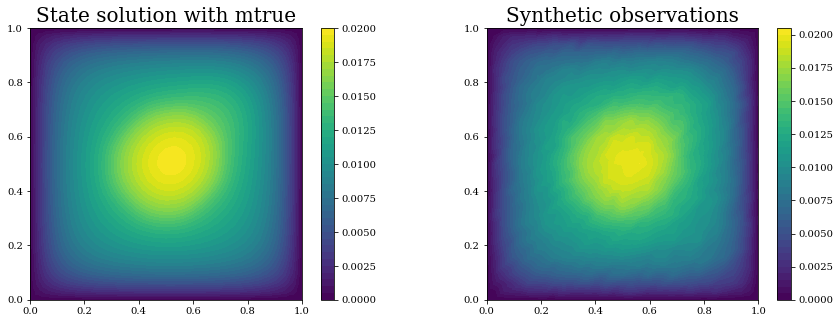

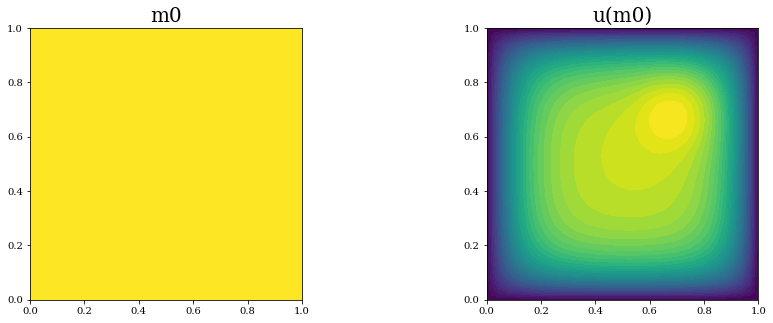

Iteration 0
Iteration 50
Iteration 100
Iteration 150
Iteration 200
Iteration 250
Iteration 300
Iteration 350
Iteration 400
Iteration 450
Iteration 500
Iteration 550
Iteration 600
Iteration 650
Iteration 700
Iteration 750
Iteration 800
Iteration 850
Iteration 900
Iteration 950
Steepest descent did not converge in  1000  iterations


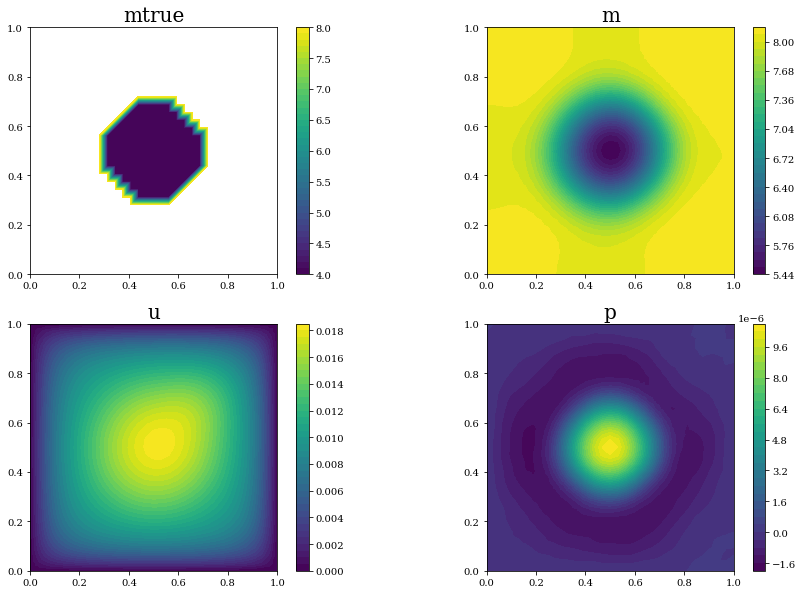

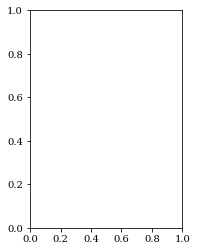

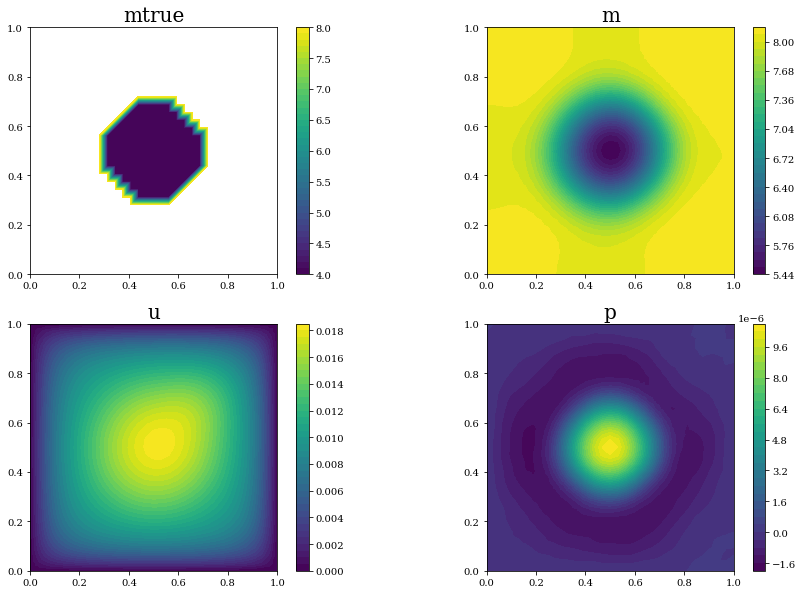

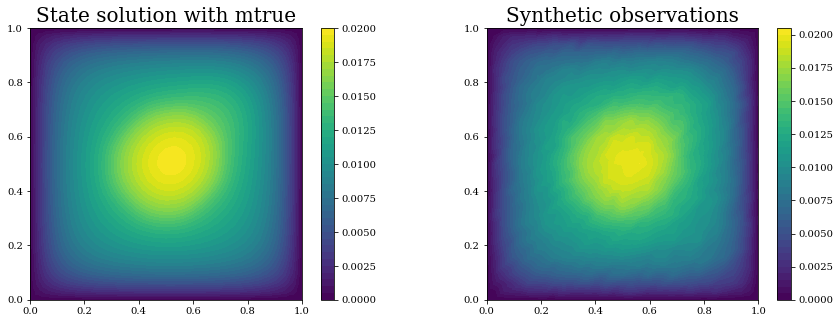

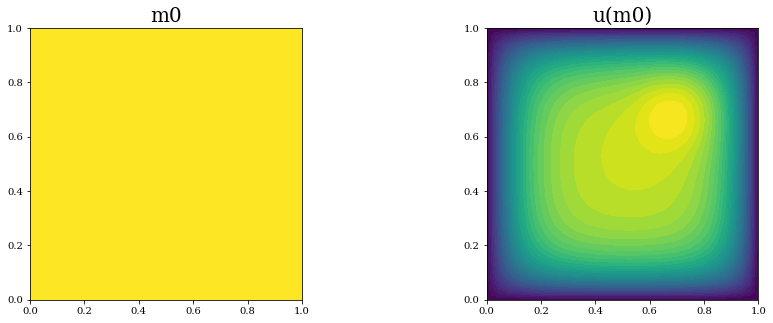

Iteration 0
Iteration 50
Iteration 100
Iteration 150
Iteration 200
Iteration 250
Iteration 300
Iteration 350
Iteration 400
Iteration 450
Iteration 500
Iteration 550
Iteration 600
Iteration 650
Iteration 700
Iteration 750
Iteration 800
Iteration 850
Iteration 900
Iteration 950
Steepest descent did not converge in  1000  iterations


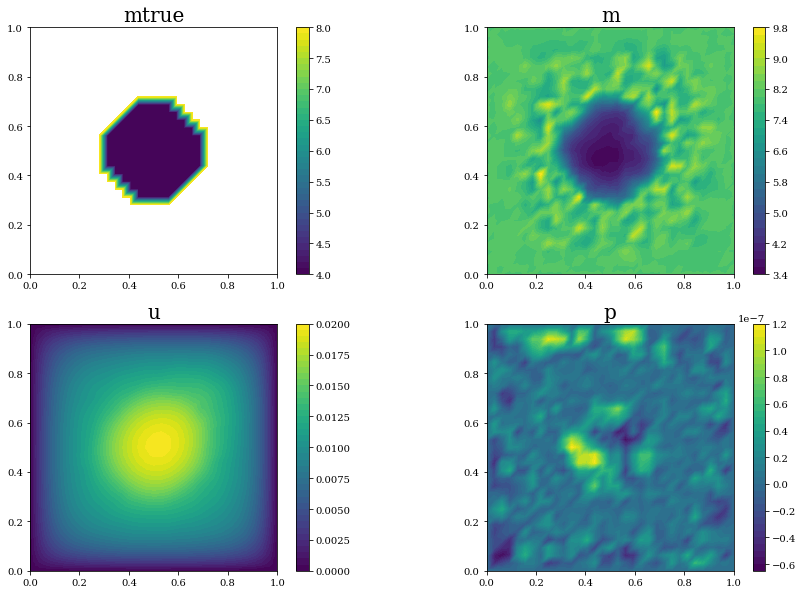

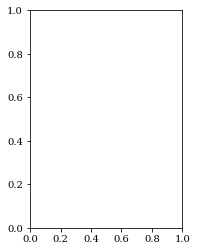

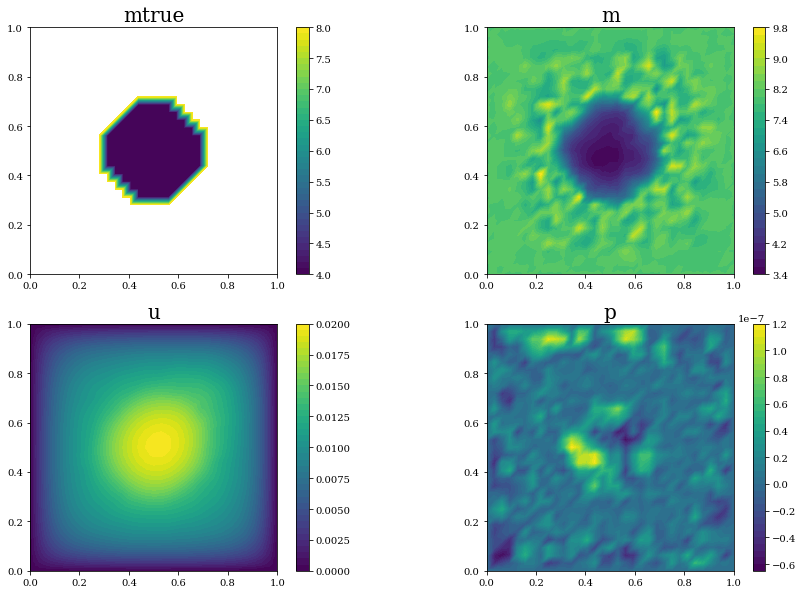

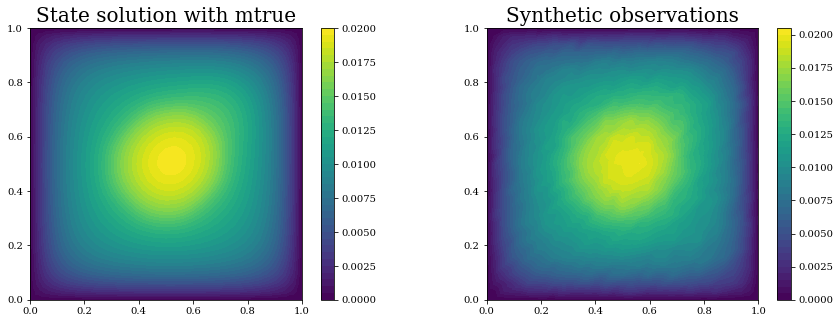

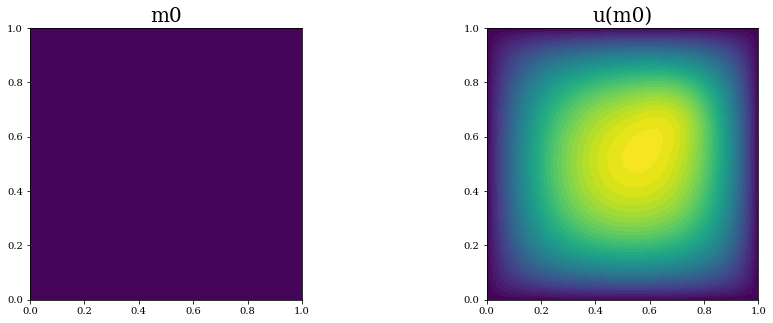

Iteration 0
Iteration 50
Iteration 100
Iteration 150
Iteration 200
Iteration 250
Iteration 300
Iteration 350
Iteration 400
Iteration 450
Iteration 500
Iteration 550
Iteration 600
Iteration 650
Iteration 700
Iteration 750
Iteration 800
Iteration 850
Iteration 900
Iteration 950
Steepest descent did not converge in  1000  iterations


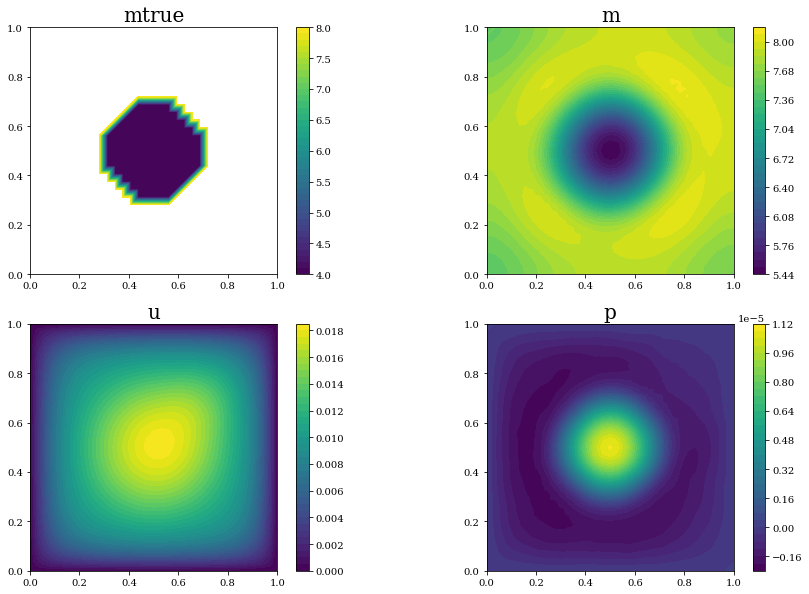

(1089,
 1000,
 2.3240073000191944e-08,
 1.1576247025008994e-07,
 9.749599906911627e-08,
 1.8266471180973676e-08)

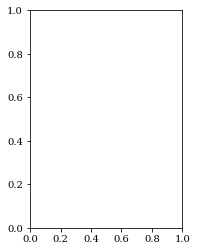

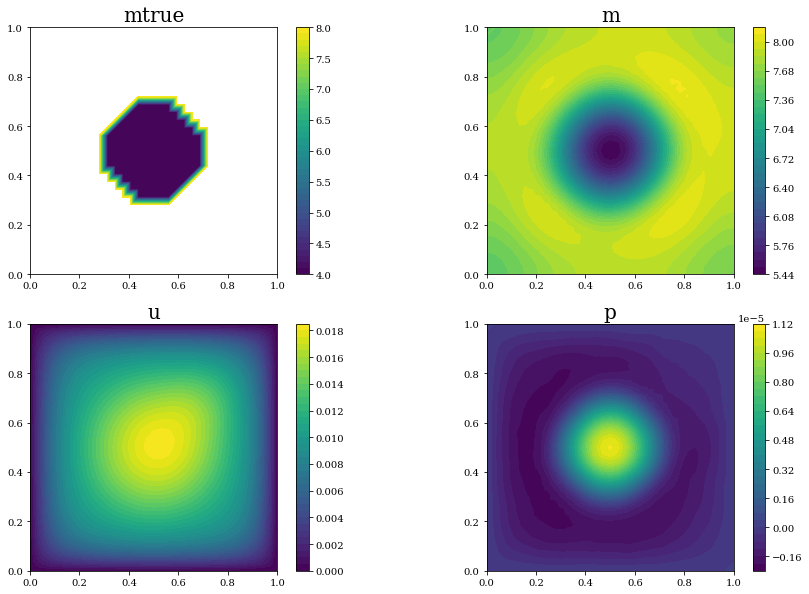

In [28]:
n = 32
noise_level = 0.01
plotting = True

# Cases - with regularization
beta = 1e-8
casename = "2_1part_a"
AdrInverseProblem(n, n, beta, noise_level, regularization='h1', plotting=plotting, starting_location='high', run_name=casename)

beta = 0.0
casename = "2_1part_b"
AdrInverseProblem(n, n, beta, noise_level, regularization='h1', plotting=plotting, starting_location='high', run_name=casename)

beta = 1e-8
casename = "2_1part_c"
AdrInverseProblem(n, n, beta, noise_level, regularization='h1', plotting=plotting, starting_location='low', run_name=casename)

# Part 2: $TV$ regularization

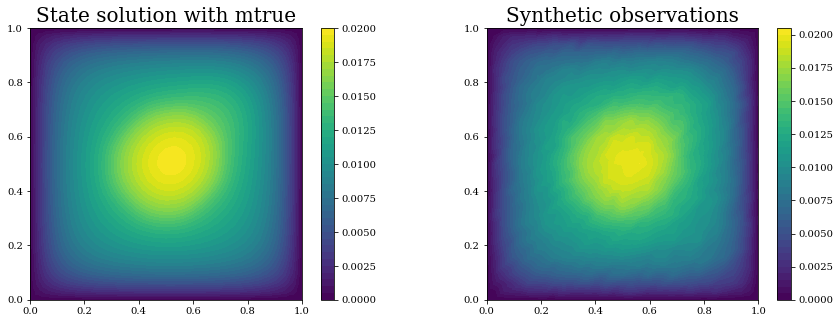

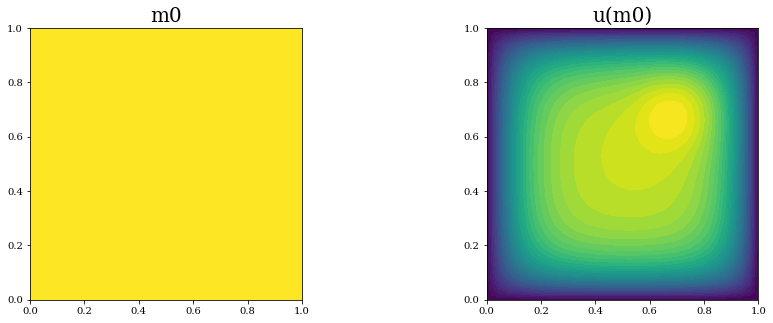

Iteration 0
Iteration 50
Iteration 100
Iteration 150
Iteration 200
Iteration 250
Iteration 300
Iteration 350
Iteration 400
Iteration 450
Iteration 500
Iteration 550
Iteration 600
Iteration 650
Iteration 700
Iteration 750
Iteration 800
Iteration 850
Iteration 900
Iteration 950
Steepest descent did not converge in  1000  iterations


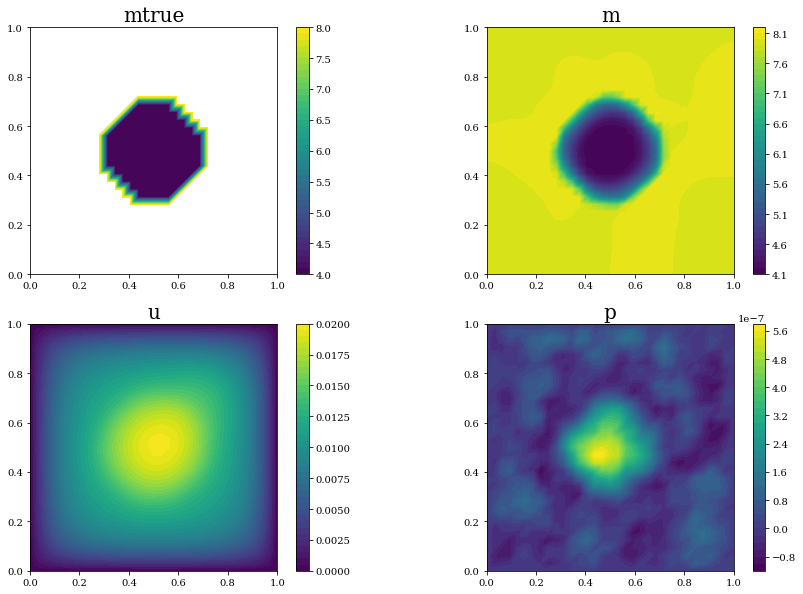

(1089,
 1000,
 2.3240073000191944e-08,
 1.4170111537642728e-08,
 1.1631192912072117e-08,
 2.53891862557061e-09)

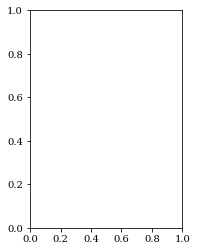

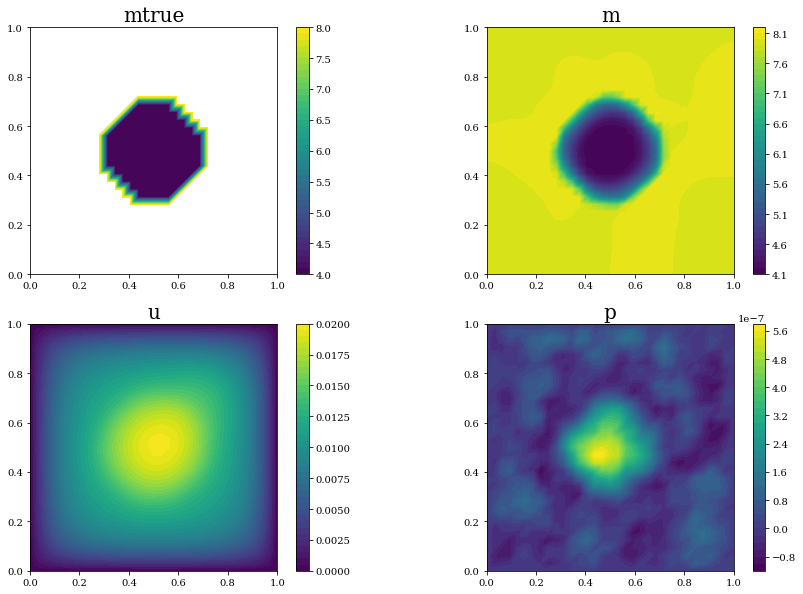

In [29]:
n = 32
noise_level = 0.01
plotting = True

beta = 1e-9
casename = "2_2_1e-9"
AdrInverseProblem(n, n, beta, noise_level, regularization='tv', plotting=plotting, starting_location='hi', run_name=casename)